# Rainfall projections

In [1]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import glob
import calendar
import seaborn as sns
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *
from scipy import stats
import itertools

In [2]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

<Client: 'tcp://127.0.0.1:36291' processes=10 threads=10, memory=586.73 GiB>

### Observed trend in cumulative annual rainfall

In [3]:
from scipy.stats import norm, linregress

def linregress_slope_stderr(y, x):
    mask = np.isfinite(y)
    if mask.sum() < 2:
        return np.nan, np.nan
    res = linregress(x[mask], y[mask])
    return res.slope, res.stderr

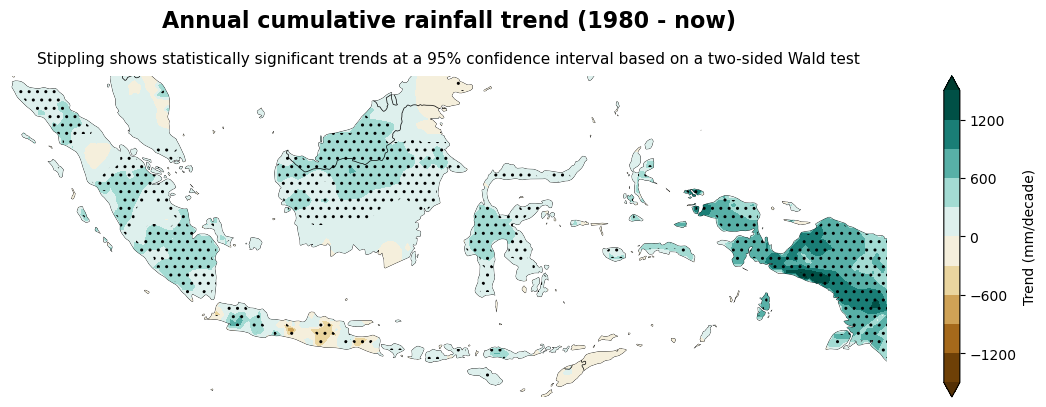

CPU times: user 16.4 s, sys: 2.27 s, total: 18.7 s
Wall time: 18.1 s


<Figure size 640x480 with 0 Axes>

In [4]:
%%time
SACAD_rain_dly = xr.open_dataset('/g/data/qz03/wp3/data/obs/wind-and-rain/gridded-SACAD/rr_0.25deg_reg_v2.0_saobs.nc').rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']), lon=slice(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max']))
pr_annual = SACAD_rain_dly.rr.resample(time='YE').sum()
years = pr_annual['time'].dt.year
pr_annual = pr_annual.assign_coords(time_in_years=years.astype(float))

slope, stderr = xr.apply_ufunc(linregress_slope_stderr,
    pr_annual,
    pr_annual['time_in_years'],
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float])

sig = np.abs(slope / stderr) > norm.ppf(0.975) # wald test for 90% confidence
fig, ax = plt.subplots(figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
cf = ax.contourf(slope['lon'], slope['lat'], 10*slope, cmap='BrBG', extend='both', levels = np.linspace(-1500, 1500, 11))
ax.contourf(
    slope['lon'], slope['lat'], sig.where(sig, np.nan),
    levels=[0.5, 1.5],  # just to trigger the mask
    colors='none', hatches=['..'], alpha=0)

fig.colorbar(cf, ax=ax, label='Trend (mm/decade)')
ax.set_title('Annual cumulative rainfall trend (1980 - now)', pad=35, fontsize=16, fontweight='bold')
ax.text(0.5, 1.04,  "Stippling shows statistically significant trends at a 95% confidence interval based on a two-sided Wald test", fontsize=11, transform=ax.transAxes, ha='center')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
ax.add_feature(cfeature.OCEAN, zorder=10, facecolor='white', alpha=1)
ax.set_frame_on(False)
plt.tight_layout()
plt.show()
plt.clf()


### Projected change to cumulative annual rainfall

In [5]:
sys.path.append('/g/data/mn51/users/jb6465/code/drought-github/submodules/gwls')
from gwl import *

In [6]:
pr_hist_files = [file for file in glob.glob('/g/data/qz03/wp3/data/proj/mon/pr/*.nc') if 'historical' in file]
pr_ssp126_files = [file for file in glob.glob('/g/data/qz03/wp3/data/proj/mon/pr/*.nc') if 'ssp126' in file]
pr_ssp370_files = [file for file in glob.glob('/g/data/qz03/wp3/data/proj/mon/pr/*.nc') if 'ssp370' in file]

In [7]:
%%time
annual_change_dict = {}
for scenario in ['ssp370', 'ssp126']:
    print(f'-------------------- {scenario} --------------------')
    annual_change_dict[scenario]={}
    for hist_file in pr_hist_files:
        gcm = hist_file.split('/')[-1].split('_')[2]
        variant_id = hist_file.split('/')[-1].split('_')[4]
        rcm = hist_file.split('/')[-1].split('_')[5]+'_'+hist_file.split('/')[-1].split('_')[6]
        print(f'{gcm}_{variant_id}_{rcm}')
        
        ssp126_file = [file for file in pr_ssp126_files if all(x in file for x in (gcm, rcm, variant_id))][0]
        ssp370_file = [file for file in pr_ssp370_files if all(x in file for x in (gcm, rcm, variant_id))][0]
        pr_cube = xr.open_mfdataset([hist_file, [file for file in pr_ssp370_files if all(x in file for x in (gcm, rcm, variant_id))][0]], combine='nested', concat_dim='time',parallel=True, engine='netcdf4') if scenario =='ssp370' else xr.open_mfdataset([hist_file, [file for file in pr_ssp126_files if all(x in file for x in (gcm, rcm, variant_id))][0]],combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
        
        syear, eyear = get_GWL_syear_eyear('CMIP6', gcm, variant_id, scenario, 1.2) #have to use this instead of get_GWL_timeslice bc of cftime errors
        gwl12_xr = pr_cube.pr.sel(time=pr_cube['time'].dt.year.isin(range(syear, eyear+1))).compute()
        gwl12_annual_mean = ((gwl12_xr*86400).resample(time='YE').sum()).mean(dim='time')
                
        gwl_dict = {}
        for gwl in [1.5, 2.0, 3.0]:
            try:
                syear, eyear = get_GWL_syear_eyear('CMIP6', gcm, variant_id, scenario, gwl) 
                gwlx_xr = pr_cube.pr.sel(time=pr_cube['time'].dt.year.isin(range(syear, eyear+1))).compute()
                gwlx_annual_mean = ((gwlx_xr*86400).resample(time='YE').sum()).mean(dim='time')
                gwl_dict[gwl] = 100*(gwlx_annual_mean-gwl12_annual_mean)/gwl12_annual_mean
            except ValueError:
                print(f'* {gcm}_{variant_id}_{rcm} ssp126 did not reach {gwl}°C')
                continue           
        annual_change_dict[scenario][f'{gcm}_{variant_id}_{rcm}']=gwl_dict

-------------------- ssp370 --------------------
EC-Earth3_r1i1p1f1_CSIRO_CCAM-v2203-SN
MPI-ESM1-2-LR_r9i1p1f1_UQ-DEC_CCAM-v2105
CESM2_r11i1p1f1_BOM_BARPA-R
CMCC-ESM2_r1i1p1f1_CSIRO_CCAM-v2203-SN
MRI-ESM2-0_r1i1p1f1_UQ-DEC_CCAM-v2105
NorESM2-MM_r1i1p1f1_UQ-DEC_CCAMoc-v2112
ACCESS-CM2_r4i1p1f1_CSIRO_CCAM-v2203-SN
ACCESS-CM2_r4i1p1f1_BOM_BARPA-R
ACCESS-ESM1-5_r6i1p1f1_CSIRO_CCAM-v2203-SN
CMCC-ESM2_r1i1p1f1_UQ-DEC_CCAM-v2105
NorESM2-MM_r1i1p1f1_CSIRO_CCAM-v2203-SN
ACCESS-ESM1-5_r40i1p1f1_UQ-DEC_CCAMoc-v2112
MPI-ESM1-2-HR_r1i1p1f1_BOM_BARPA-R
EC-Earth3_r1i1p1f1_UQ-DEC_CCAM-v2105
EC-Earth3_r1i1p1f1_BOM_BARPA-R
CNRM-CM6-1-HR_r1i1p1f2_UQ-DEC_CCAM-v2112
ACCESS-ESM1-5_r6i1p1f1_UQ-DEC_CCAM-v2105
NorESM2-MM_r1i1p1f1_UQ-DEC_CCAM-v2112
NorESM2-MM_r1i1p1f1_BOM_BARPA-R
CESM2_r11i1p1f1_CSIRO_CCAM-v2203-SN
CMCC-ESM2_r1i1p1f1_BOM_BARPA-R
FGOALS-g3_r4i1p1f1_UQ-DEC_CCAM-v2105
ACCESS-ESM1-5_r20i1p1f1_UQ-DEC_CCAMoc-v2112
GFDL-ESM4_r1i1p1f1_UQ-DEC_CCAM-v2105
CNRM-ESM2-1_r1i1p1f2_CSIRO_CCAM-v2203-SN
ACCESS-ES

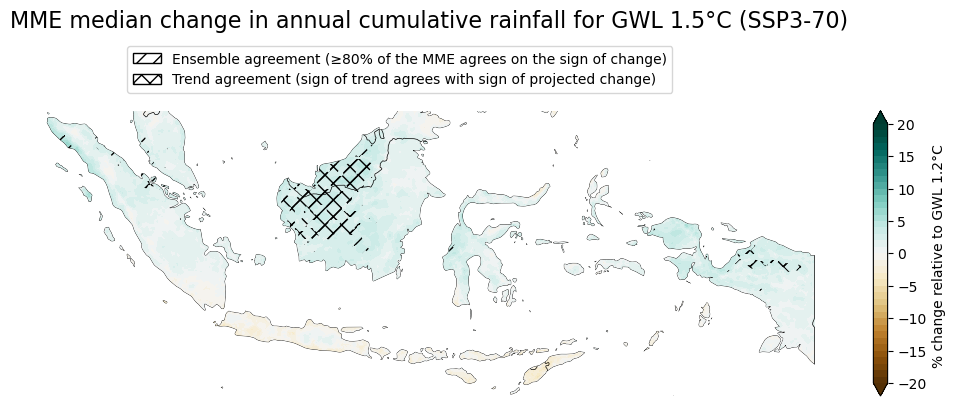

<Figure size 640x480 with 0 Axes>

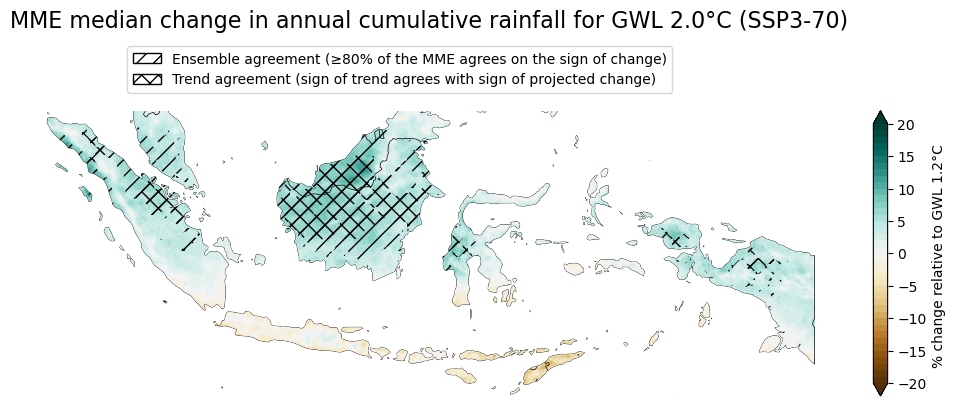

<Figure size 640x480 with 0 Axes>

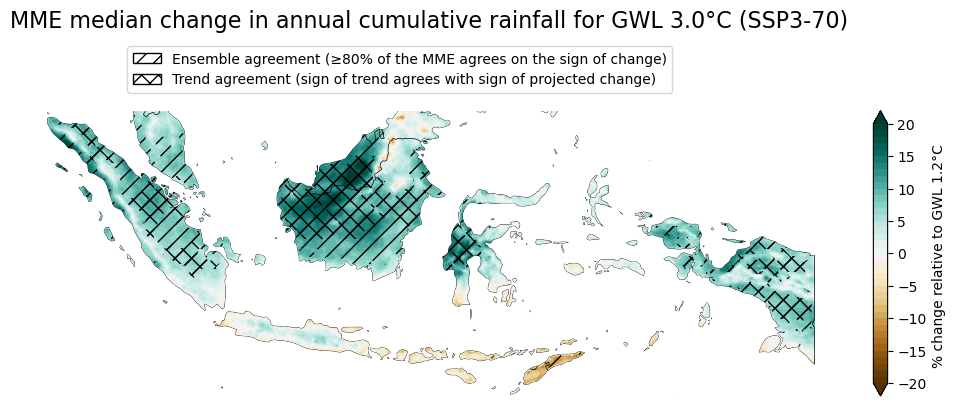

<Figure size 640x480 with 0 Axes>

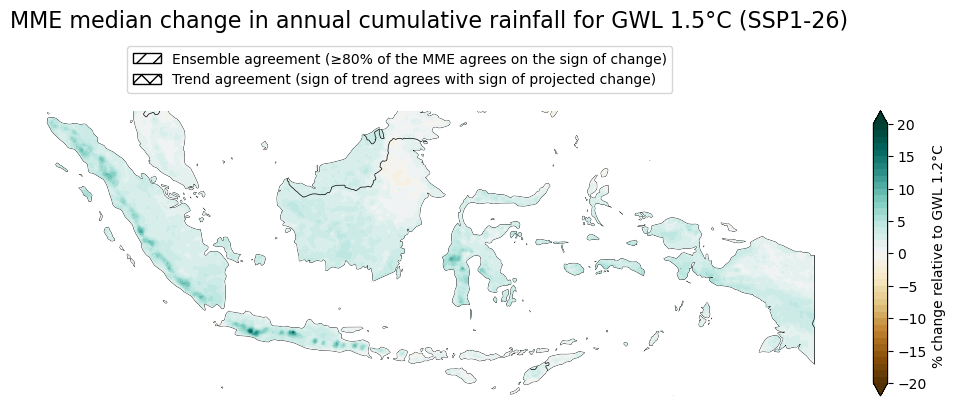

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

gwls = [1.5, 2.0, 3.0]

for scenario in ['ssp370', 'ssp126']:
    # MME_gwl_change = {gwl: [annual_change_dict[scenario].get(ens_key, {}).get(gwl, np.nan) for ens_key in annual_change_dict[scenario]] for gwl in gwls}
    MME_gwl_change = {gwl: [annual_change_dict[scenario].get(ens_key, {}).get(gwl, xr.DataArray(np.nan, dims=["lat", "lon"], coords={"lat": np.linspace(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max'], 10), "lon": np.linspace(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'], 10)})) for ens_key in annual_change_dict[scenario]] for gwl in gwls}
    MME_xr = {gwl: xr.concat([da.interp(lat=np.arange(min(d.lat.min() for d in MME_gwl_change[gwl]), max(d.lat.max() for d in MME_gwl_change[gwl]), min(np.diff(d.lat.values).min() for d in  MME_gwl_change[gwl])),
                                        lon=np.arange(min(d.lon.min() for d in MME_gwl_change[gwl]), max(d.lon.max() for d in  MME_gwl_change[gwl]), min(np.diff(d.lon.values).min() for d in MME_gwl_change[gwl]))) for da in  MME_gwl_change[gwl]], dim='ens') for gwl in gwls}

    for gwl in gwls:
        if gwl == 3.0 and scenario == 'ssp126':
            continue
        else:
            fig, ax = plt.subplots(figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
            cf = ax.contourf(MME_xr[gwl]['lon'], MME_xr[gwl]['lat'], MME_xr[gwl].median(dim='ens'), cmap='BrBG', extend='both', levels = np.linspace(-20, 20, 41))
            
            positive_agreement = (np.sign(MME_xr[gwl])==1)
            negative_agreement = (np.sign(MME_xr[gwl])==-1)
            agreement_threshold = int(0.80 * 29)
            stippling = (positive_agreement.sum(dim='ens')>agreement_threshold) + (negative_agreement.sum(dim='ens')>agreement_threshold)
            hatch_mask = np.where(stippling, 1, np.nan)
            ax.contourf(MME_xr[gwl]['lon'], MME_xr[gwl]['lat'], hatch_mask, levels=[0.5, 1.5], hatches=[r'//', None], colors='none', transform=ccrs.PlateCarree(), alpha=0)
        
        
            slope_interp = slope.interp_like(MME_xr[gwl].median(dim='ens'))
            sig_interp = sig.astype(int).interp_like(MME_xr[gwl].median(dim='ens'))
            trend_hatch = ((np.sign(slope_interp) == 1) & (hatch_mask == 1) & (sig_interp == 1))
            hatch_mask = np.where(trend_hatch, 1, np.nan)
            ax.contourf(MME_xr[gwl]['lon'], MME_xr[gwl]['lat'], hatch_mask, levels=[0.5, 1.5], hatches=[r'xx', None], colors='none', transform=ccrs.PlateCarree(), alpha=0)
            
            fig.colorbar(cf, ax=ax, label='% change relative to GWL 1.2°C ')
            
            hatch_legend = [mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label='Ensemble agreement (≥80% of the MME agrees on the sign of change)'),
                            mpatches.Patch(facecolor='white', edgecolor='black', hatch='xx', label='Trend agreement (sign of trend agrees with sign of projected change)')]
            ax.legend(handles=hatch_legend, loc='upper left', bbox_to_anchor=(0.1, 1.25))
        
            ax.set_title(f'MME median change in annual cumulative rainfall for GWL {gwl}°C (SSP{scenario[3:4]}-{scenario[4:]})', pad=60,  fontsize=16)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
            ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
            ax.add_feature(cfeature.OCEAN, zorder=10, facecolor='white', alpha=1)
            ax.set_frame_on(False)
            plt.tight_layout()
            plt.show()
            plt.clf()



In [11]:
%%time
seasonal_change_dict = {}
for scenario in ['ssp370', 'ssp126']:
    print(f'-------------------- {scenario} --------------------')
    seasonal_change_dict[scenario] = {}
    
    for hist_file in pr_hist_files:
        gcm = hist_file.split('/')[-1].split('_')[2]
        variant_id = hist_file.split('/')[-1].split('_')[4]
        rcm = hist_file.split('/')[-1].split('_')[5]+'_'+hist_file.split('/')[-1].split('_')[6]
        print(f'{gcm}_{variant_id}_{rcm}')
        
        ssp126_file = [file for file in pr_ssp126_files if all(x in file for x in (gcm, rcm, variant_id))][0]
        ssp370_file = [file for file in pr_ssp370_files if all(x in file for x in (gcm, rcm, variant_id))][0]
        pr_cube = xr.open_mfdataset([hist_file, ssp370_file] if scenario == 'ssp370' else [hist_file, ssp126_file],
                                    combine='nested', concat_dim='time', parallel=True, engine='netcdf4')
        
        # Get baseline period (GWL 1.2)
        syear, eyear = get_GWL_syear_eyear('CMIP6', gcm, variant_id, scenario, 1.2)
        gwl12_xr = pr_cube.pr.sel(time=pr_cube['time'].dt.year.isin(range(syear, eyear + 1))).compute()
        
        # Resample to get seasonal data first (DJF, MAM, JJA, SON)
        gwl12_seasonal_mean = (gwl12_xr * 86400).resample(time='QS-DEC').sum()
        
        # Group by season after resampling
        gwl12_seasonal_mean_grouped = gwl12_seasonal_mean.groupby('time.season').sum()
        
        gwl_dict = {}
        for gwl in [1.5, 2.0, 3.0]:
            try:
                syear, eyear = get_GWL_syear_eyear('CMIP6', gcm, variant_id, scenario, gwl)
                gwlx_xr = pr_cube.pr.sel(time=pr_cube['time'].dt.year.isin(range(syear, eyear + 1))).compute()
                
                # Resample to get seasonal data for the future period (GWL)
                gwlx_seasonal_mean = (gwlx_xr * 86400).resample(time='QS-DEC').sum()
                
                # Group by season after resampling
                gwlx_seasonal_mean_grouped = gwlx_seasonal_mean.groupby('time.season').sum()
                
                # Calculate percent change per season (DJF, MAM, JJA, SON)
                seasonal_change = 100 * (gwlx_seasonal_mean_grouped - gwl12_seasonal_mean_grouped) / gwl12_seasonal_mean_grouped
                gwl_dict[gwl] = seasonal_change
            except ValueError:
                print(f'* {gcm}_{variant_id}_{rcm} {scenario} did not reach {gwl}°C')
                continue
        
        # Store seasonal changes for each GCM, RCM, and variant
        seasonal_change_dict[scenario][f'{gcm}_{variant_id}_{rcm}'] = gwl_dict


-------------------- ssp370 --------------------
EC-Earth3_r1i1p1f1_CSIRO_CCAM-v2203-SN
MPI-ESM1-2-LR_r9i1p1f1_UQ-DEC_CCAM-v2105
CESM2_r11i1p1f1_BOM_BARPA-R
CMCC-ESM2_r1i1p1f1_CSIRO_CCAM-v2203-SN
MRI-ESM2-0_r1i1p1f1_UQ-DEC_CCAM-v2105
NorESM2-MM_r1i1p1f1_UQ-DEC_CCAMoc-v2112
ACCESS-CM2_r4i1p1f1_CSIRO_CCAM-v2203-SN
ACCESS-CM2_r4i1p1f1_BOM_BARPA-R
ACCESS-ESM1-5_r6i1p1f1_CSIRO_CCAM-v2203-SN
CMCC-ESM2_r1i1p1f1_UQ-DEC_CCAM-v2105
NorESM2-MM_r1i1p1f1_CSIRO_CCAM-v2203-SN
ACCESS-ESM1-5_r40i1p1f1_UQ-DEC_CCAMoc-v2112
MPI-ESM1-2-HR_r1i1p1f1_BOM_BARPA-R
EC-Earth3_r1i1p1f1_UQ-DEC_CCAM-v2105
EC-Earth3_r1i1p1f1_BOM_BARPA-R
CNRM-CM6-1-HR_r1i1p1f2_UQ-DEC_CCAM-v2112
ACCESS-ESM1-5_r6i1p1f1_UQ-DEC_CCAM-v2105
NorESM2-MM_r1i1p1f1_UQ-DEC_CCAM-v2112
NorESM2-MM_r1i1p1f1_BOM_BARPA-R
CESM2_r11i1p1f1_CSIRO_CCAM-v2203-SN
CMCC-ESM2_r1i1p1f1_BOM_BARPA-R
FGOALS-g3_r4i1p1f1_UQ-DEC_CCAM-v2105
ACCESS-ESM1-5_r20i1p1f1_UQ-DEC_CCAMoc-v2112
GFDL-ESM4_r1i1p1f1_UQ-DEC_CCAM-v2105
CNRM-ESM2-1_r1i1p1f2_CSIRO_CCAM-v2203-SN
ACCESS-ES

<Figure size 640x480 with 0 Axes>

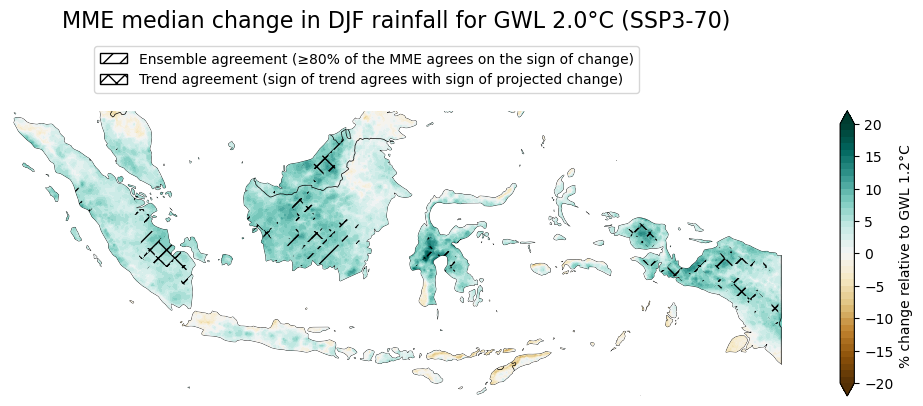

<Figure size 640x480 with 0 Axes>

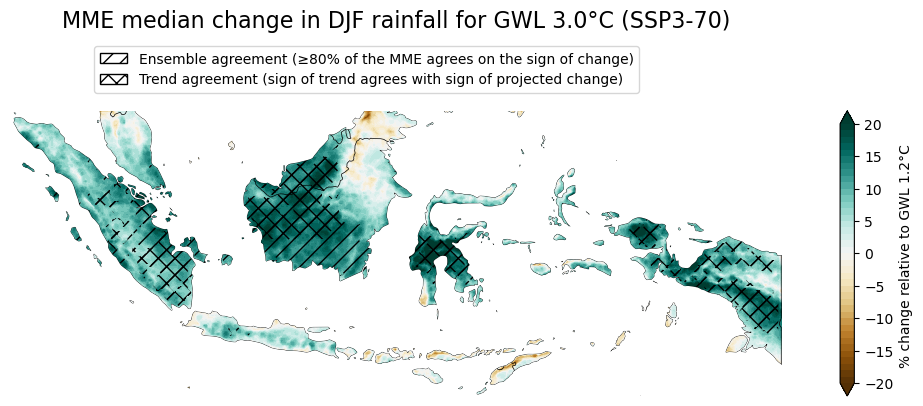

<Figure size 640x480 with 0 Axes>

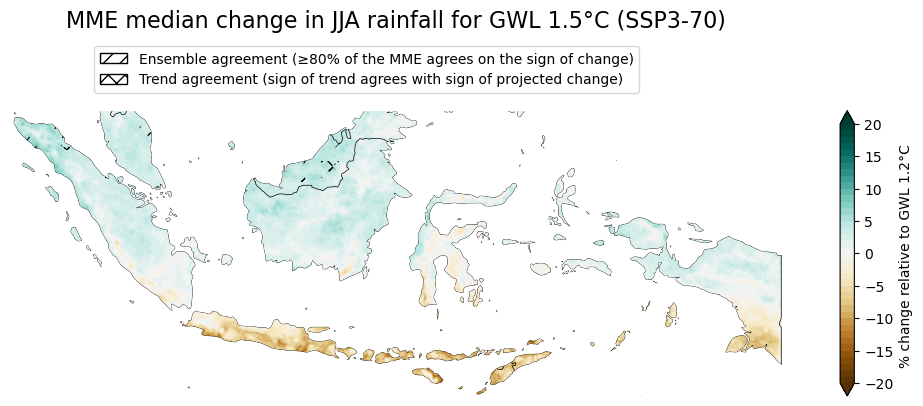

<Figure size 640x480 with 0 Axes>

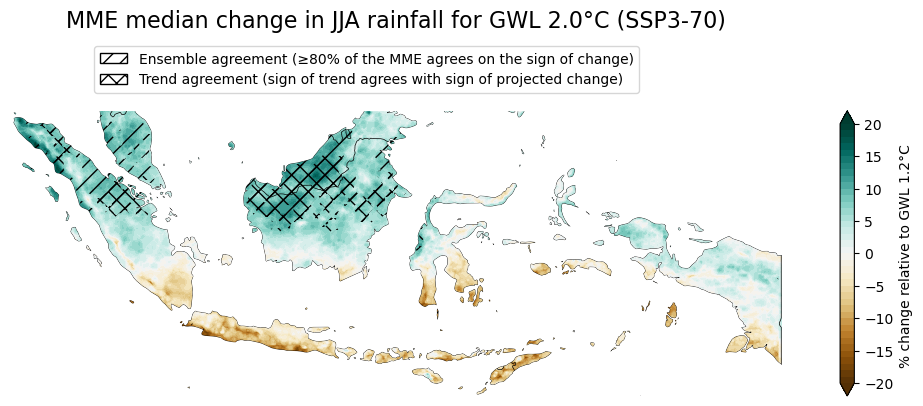

<Figure size 640x480 with 0 Axes>

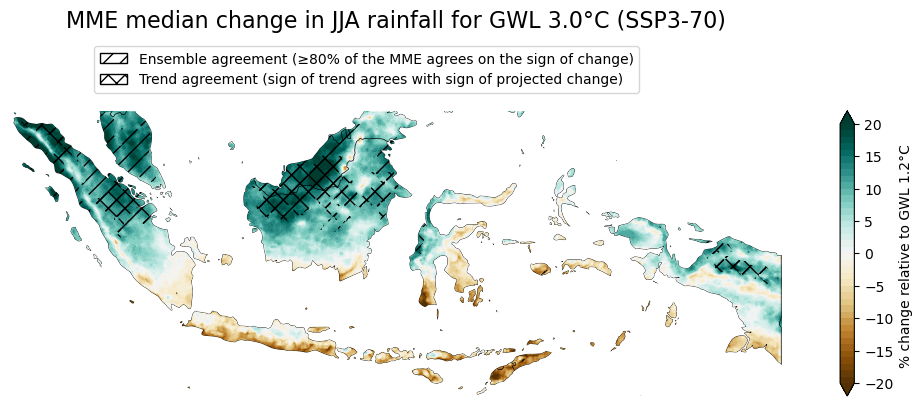

<Figure size 640x480 with 0 Axes>

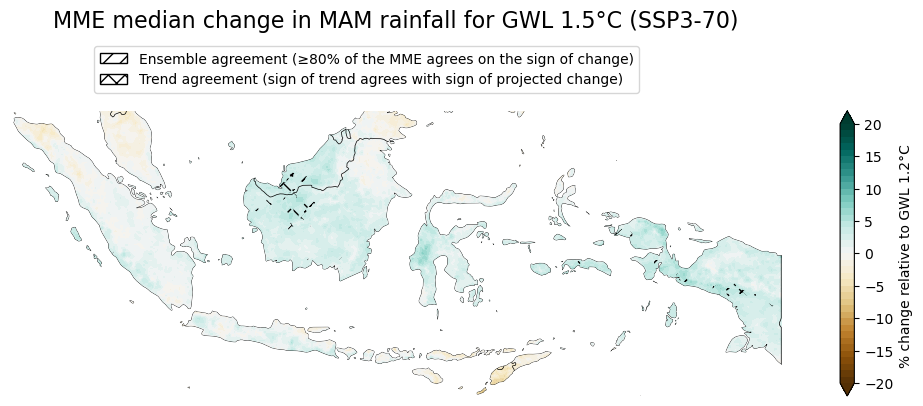

<Figure size 640x480 with 0 Axes>

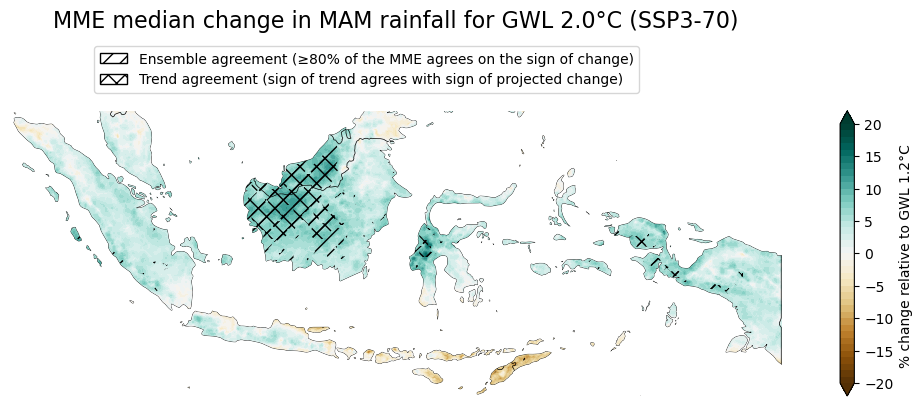

<Figure size 640x480 with 0 Axes>

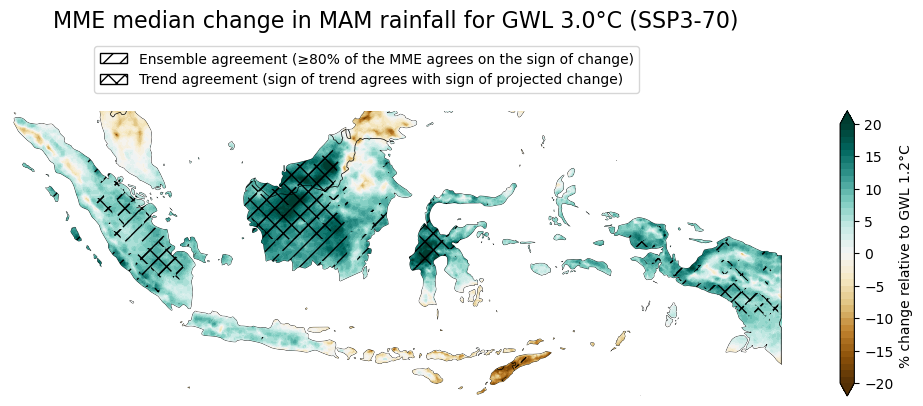

<Figure size 640x480 with 0 Axes>

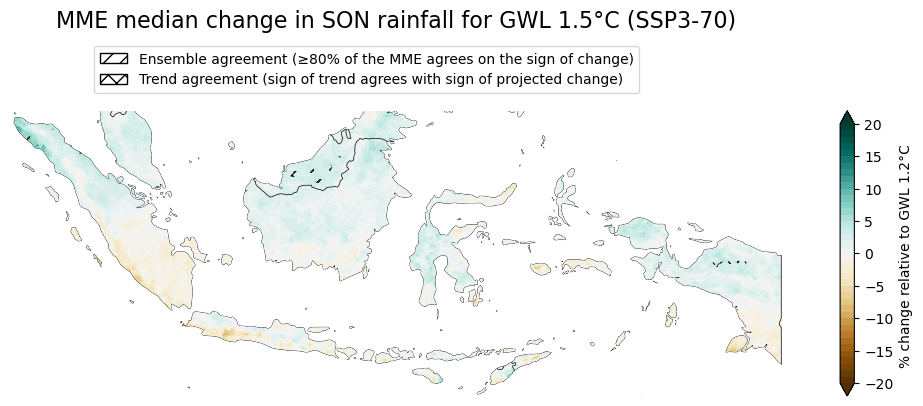

<Figure size 640x480 with 0 Axes>

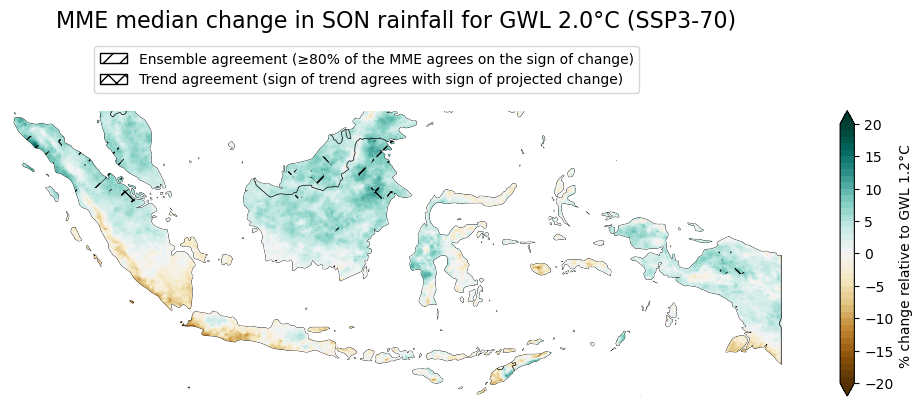

<Figure size 640x480 with 0 Axes>

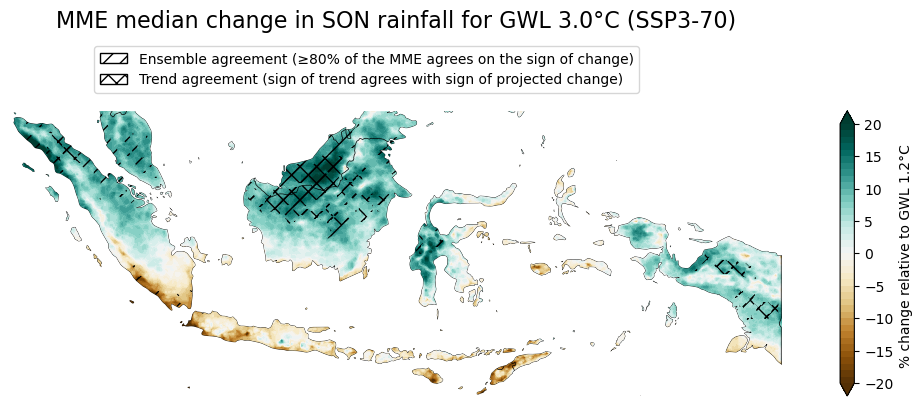

<Figure size 640x480 with 0 Axes>

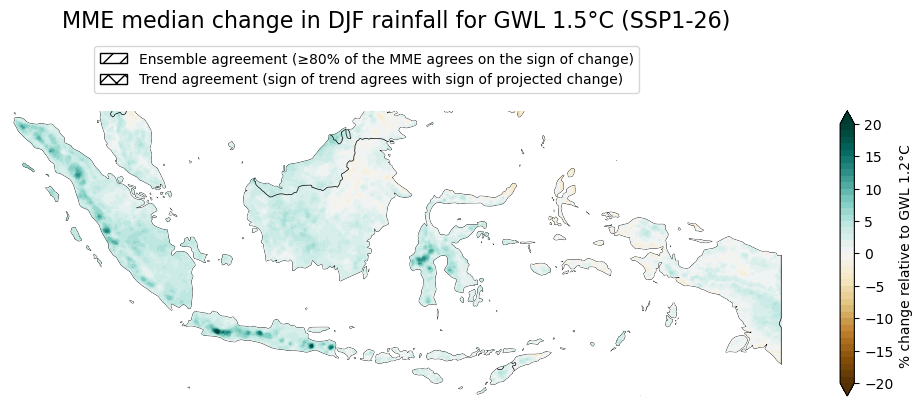

<Figure size 640x480 with 0 Axes>

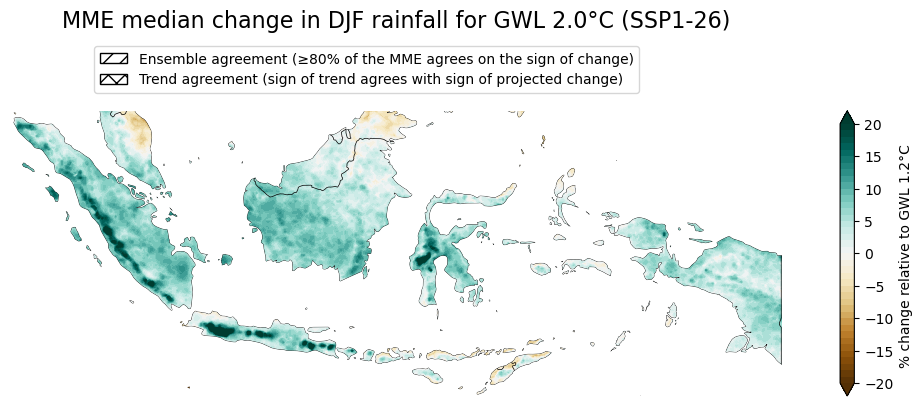

<Figure size 640x480 with 0 Axes>

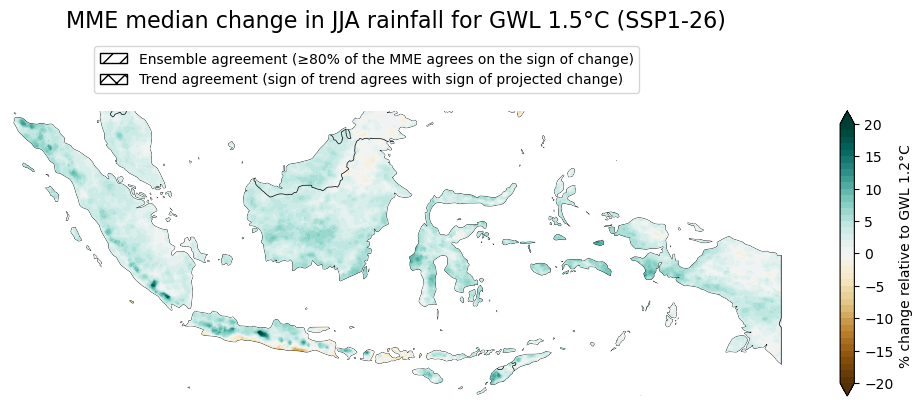

<Figure size 640x480 with 0 Axes>

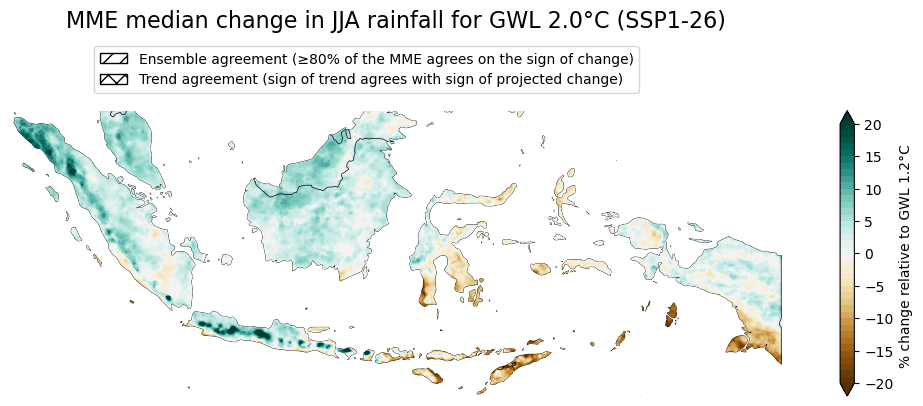

<Figure size 640x480 with 0 Axes>

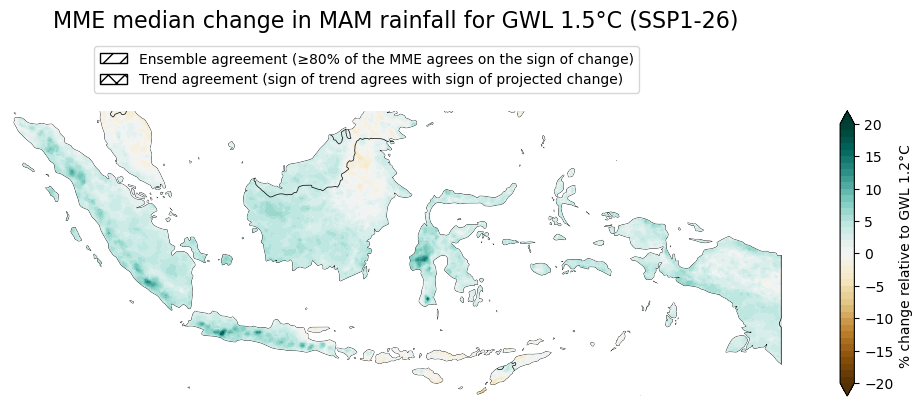

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

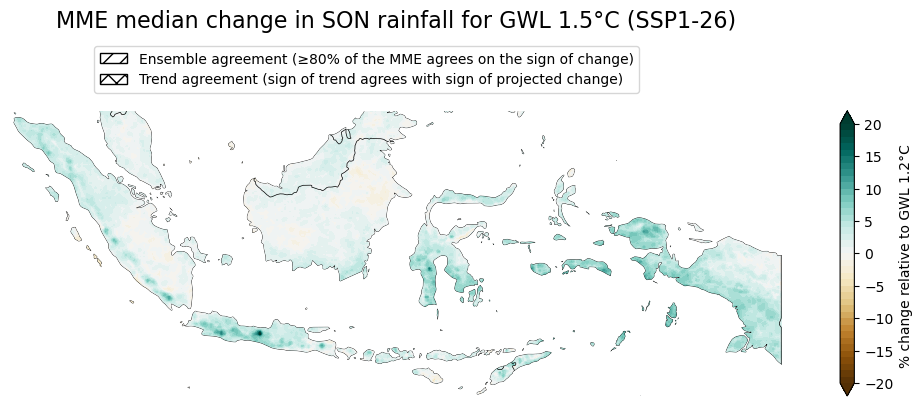

<Figure size 640x480 with 0 Axes>

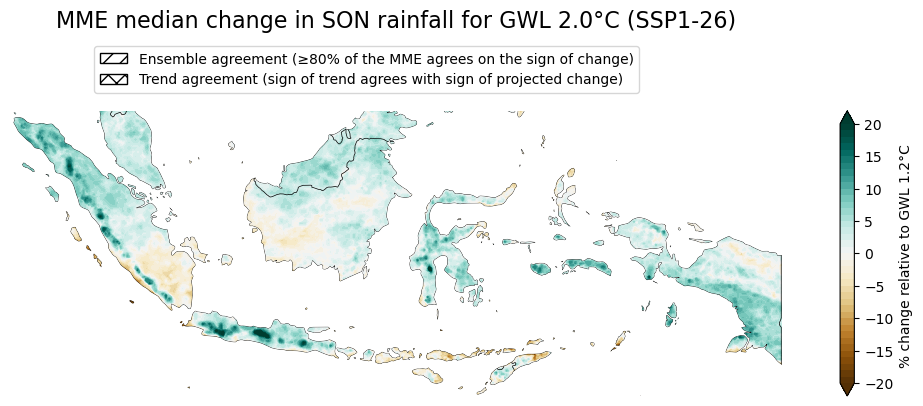

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

gwls = [1.5, 2.0, 3.0]

for scenario in ['ssp370', 'ssp126']:
    # MME_gwl_change = {gwl: [annual_change_dict[scenario].get(ens_key, {}).get(gwl, np.nan) for ens_key in annual_change_dict[scenario]] for gwl in gwls}
    MME_gwl_change = {gwl: [seasonal_change_dict[scenario].get(ens_key, {}).get(gwl, xr.DataArray(np.nan, dims=["season", "lat", "lon"], coords={"season": np.array(['DJF', 'JJA', 'MAM', 'SON']), "lat": np.linspace(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max'], 10), "lon": np.linspace(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'], 10)})) for ens_key in seasonal_change_dict[scenario]] for gwl in gwls}
    MME_xr = {gwl: xr.concat([da.interp(lat=np.arange(min(d.lat.min() for d in MME_gwl_change[gwl]), max(d.lat.max() for d in MME_gwl_change[gwl]), min(np.diff(d.lat.values).min() for d in  MME_gwl_change[gwl])),
                                        lon=np.arange(min(d.lon.min() for d in MME_gwl_change[gwl]), max(d.lon.max() for d in  MME_gwl_change[gwl]), min(np.diff(d.lon.values).min() for d in MME_gwl_change[gwl]))) for da in  MME_gwl_change[gwl]], dim='ens') for gwl in gwls}
    for season in ['DJF', 'JJA', 'MAM', 'SON']:
        for gwl in gwls:
            if gwl == 3.0 and scenario == 'ssp126':
                continue
            else:
                fig, ax = plt.subplots(figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
                cf = ax.contourf(MME_xr[gwl].sel(season=season)['lon'], MME_xr[gwl].sel(season=season)['lat'], MME_xr[gwl].sel(season=season).median(dim='ens'), cmap='BrBG', extend='both', levels = np.linspace(-20, 20, 41))
                
                positive_agreement = (np.sign(MME_xr[gwl].sel(season=season))==1)
                negative_agreement = (np.sign(MME_xr[gwl].sel(season=season))==-1)
                agreement_threshold = int(0.80 * 29)
                stippling = (positive_agreement.sum(dim='ens')>agreement_threshold) + (negative_agreement.sum(dim='ens')>agreement_threshold)
                hatch_mask = np.where(stippling, 1, np.nan)
                ax.contourf(MME_xr[gwl].sel(season=season)['lon'], MME_xr[gwl].sel(season=season)['lat'], hatch_mask, levels=[0.5, 1.5], hatches=[r'//', None], colors='none', transform=ccrs.PlateCarree(), alpha=0)
            
            
                slope_interp = slope.interp_like(MME_xr[gwl].sel(season=season).median(dim='ens'))
                sig_interp = sig.astype(int).interp_like(MME_xr[gwl].sel(season=season).median(dim='ens'))
                trend_hatch = ((np.sign(slope_interp) == 1) & (hatch_mask == 1) & (sig_interp == 1))
                hatch_mask = np.where(trend_hatch, 1, np.nan)
                ax.contourf(MME_xr[gwl].sel(season=season)['lon'], MME_xr[gwl].sel(season=season)['lat'], hatch_mask, levels=[0.5, 1.5], hatches=[r'xx', None], colors='none', transform=ccrs.PlateCarree(), alpha=0)
                
                fig.colorbar(cf, ax=ax, label='% change relative to GWL 1.2°C ')
                
                hatch_legend = [mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label='Ensemble agreement (≥80% of the MME agrees on the sign of change)'),
                                mpatches.Patch(facecolor='white', edgecolor='black', hatch='xx', label='Trend agreement (sign of trend agrees with sign of projected change)')]
                ax.legend(handles=hatch_legend, loc='upper left', bbox_to_anchor=(0.1, 1.25))
            
                ax.set_title(f'MME median change in {season} rainfall for GWL {gwl}°C (SSP{scenario[3:4]}-{scenario[4:]})', pad=60,  fontsize=16)
                ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
                ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
                ax.add_feature(cfeature.OCEAN, zorder=10, facecolor='white', alpha=1)
                ax.set_frame_on(False)
                plt.tight_layout()
                plt.show()
                plt.clf()
    
